# Photoredox_Yield_Iterative: GGH Method Benchmark

Apply the Gradient-Guided Hypothesis (GGH) iterative method to the Photoredox Yield dataset.

**Dataset**: Photoredox yield prediction (Merck 2021, 1649 reactions)
- 4 hypothesis classes for photocatalyst moles
- Target: UPLCMS yield


In [28]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

from GGH.data_ops import DataOperator
from GGH.selection_algorithms import AlgoModulators, compute_individual_grads_nothread
from GGH.models import initialize_model, load_model
from GGH.train_val_loop import TrainValidationManager
from GGH.inspector import Inspector, visualize_train_val_error, selection_histograms
from GGH.custom_optimizer import CustomAdam
from sklearn.metrics import r2_score
from torch.autograd import grad
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def set_to_deterministic(rand_state):
    import random
    random.seed(rand_state)
    np.random.seed(rand_state)
    torch.manual_seed(rand_state)
    torch.set_num_threads(1)
    torch.use_deterministic_algorithms(True)

print("Imports successful!")

Imports successful!


In [29]:
# Data configuration for Photoredox Yield dataset
data_path = '../data/photoredox_yield/photo_redox_merck2021_1649reactions.csv'
results_path = "../saved_results/Photoredox Yield Iterative"

# Input, target, and missing variables
inpt_vars = ['aryl_halides', 'photocalysts', 'piperidines_moles']
target_vars = ['uplcms']
miss_vars = ['photocalysts_moles']

# Hypothesis values for photocatalyst moles (4 classes)
hypothesis = [[0.02, 0.05, 0.50, 5.0]]

# Simulation parameters
partial_perc = 0.30  # 10% partial data
rand_state = 42

# Model parameters
hidden_size = 32

# Create results directory if needed
import os
os.makedirs(results_path, exist_ok=True)

print(f"Data path: {data_path}")
print(f"Input variables: {inpt_vars}")
print(f"Target variables: {target_vars}")
print(f"Missing variables: {miss_vars}")
print(f"Hypothesis values: {hypothesis[0]}")
print(f"Number of hypothesis classes: {len(hypothesis[0])}")

Data path: ../data/photoredox_yield/photo_redox_merck2021_1649reactions.csv
Input variables: ['aryl_halides', 'photocalysts', 'piperidines_moles']
Target variables: ['uplcms']
Missing variables: ['photocalysts_moles']
Hypothesis values: [0.02, 0.05, 0.5, 5.0]
Number of hypothesis classes: 4


## Model Definitions

In [30]:
class HypothesisAmplifyingModel(nn.Module):
    """
    Neural network that amplifies the impact of hypothesis feature on gradients.
    
    Architecture:
    - Shared features (non-hypothesis): small embedding
    - Hypothesis feature: separate, larger embedding path
    - Concatenate and process through final layers
    """
    def __init__(self, n_shared_features, n_hypothesis_features=1, 
                 shared_hidden=16, hypothesis_hidden=32, final_hidden=32, output_size=1):
        super().__init__()
        
        # Shared features path (smaller)
        self.shared_path = nn.Sequential(
            nn.Linear(n_shared_features, shared_hidden),
            nn.ReLU(),
        )
        
        # Hypothesis feature path (larger - amplifies its importance)
        self.hypothesis_path = nn.Sequential(
            nn.Linear(n_hypothesis_features, hypothesis_hidden),
            nn.ReLU(),
            nn.Linear(hypothesis_hidden, hypothesis_hidden),
            nn.ReLU(),
        )
        
        # Combined path
        combined_size = shared_hidden + hypothesis_hidden
        self.final_path = nn.Sequential(
            nn.Linear(combined_size, final_hidden),
            nn.ReLU(),
            nn.Linear(final_hidden, output_size)
        )
        
        self.n_shared = n_shared_features
        
    def forward(self, x):
        # Split input: shared features vs hypothesis feature
        shared_features = x[:, :self.n_shared]
        hypothesis_feature = x[:, self.n_shared:]
        
        # Process separately
        shared_emb = self.shared_path(shared_features)
        hypothesis_emb = self.hypothesis_path(hypothesis_feature)
        
        # Combine and predict
        combined = torch.cat([shared_emb, hypothesis_emb], dim=1)
        return self.final_path(combined)


class StandardModel(nn.Module):
    """Standard MLP for comparison."""
    def __init__(self, input_size, hidden_size=32, output_size=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.net(x)

print("Models defined.")

Models defined.


## Training Classes

In [31]:
class UnbiasedTrainer:
    """
    Train on ALL hypotheses equally (no selection).
    Track per-hypothesis losses and gradients in the last N epochs.
    Used for Iteration 1.
    """
    def __init__(self, DO, model, lr=0.001, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        self.hyp_per_sample = DO.num_hyp_comb
        
        # Tracking data
        self.loss_history = {}  # global_id -> list of losses per epoch
        self.gradient_history = {}  # global_id -> list of gradient vectors
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        """Train one epoch on ALL hypotheses equally."""
        self.model.train()
        total_loss = 0
        num_batches = 0
        
        for batch_idx, (inputs, targets, global_ids) in enumerate(dataloader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            # Standard forward pass on ALL hypotheses
            predictions = self.model(inputs)
            
            # Compute loss (mean over all hypotheses - no selection)
            individual_losses = self.criterion(predictions, targets).mean(dim=1)
            batch_loss = individual_losses.mean()
            
            # Track per-hypothesis data if in analysis window
            if track_data:
                self._track_hypothesis_data(inputs, targets, global_ids, individual_losses)
            
            # Standard backprop on ALL hypotheses
            self.optimizer.zero_grad()
            batch_loss.backward()
            self.optimizer.step()
            
            total_loss += batch_loss.item()
            num_batches += 1
        
        return total_loss / num_batches
    
    def _track_hypothesis_data(self, inputs, targets, global_ids, losses):
        """Track loss and gradient for each hypothesis in the batch."""
        self.model.eval()
        
        for i in range(len(inputs)):
            gid = global_ids[i].item()
            
            # Track loss
            if gid not in self.loss_history:
                self.loss_history[gid] = []
            self.loss_history[gid].append(losses[i].item())
            
            # Compute and track gradient for this hypothesis
            inp = inputs[i:i+1].clone().requires_grad_(True)
            pred = self.model(inp)
            loss = nn.MSELoss()(pred, targets[i:i+1])
            
            # Get gradient w.r.t. last layer weights
            params = list(self.model.parameters())
            grad_param = grad(loss, params[-2], retain_graph=False)[0]
            grad_vec = grad_param.flatten().detach().cpu().numpy()
            
            if gid not in self.gradient_history:
                self.gradient_history[gid] = []
            self.gradient_history[gid].append(grad_vec)
        
        self.model.train()
    
    def get_hypothesis_analysis(self):
        """Compile analysis results for each hypothesis."""
        analysis = {}
        
        for gid in self.loss_history:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_history[gid]),
                'loss_std': np.std(self.loss_history[gid]),
                'loss_trajectory': self.loss_history[gid],
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        
        return analysis

print("UnbiasedTrainer defined.")

UnbiasedTrainer defined.


In [32]:
class BiasedTrainer:
    """
    Train on selected hypotheses + weighted partial data.
    Used for Iteration 2.
    """
    def __init__(self, DO, model, selected_gids, partial_gids, partial_weight, lr=0.001, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        self.hyp_per_sample = DO.num_hyp_comb
        
        self.selected_gids = set(selected_gids)  # Top N% from Iteration 1
        self.partial_gids = set(partial_gids)    # Partial data (known correct)
        self.partial_weight = partial_weight
        
        # Tracking data for analysis
        self.loss_history = {}
        self.gradient_history = {}
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        """Train one epoch on selected + partial data."""
        self.model.train()
        total_loss = 0
        total_weight = 0
        
        for batch_idx, (inputs, targets, global_ids) in enumerate(dataloader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            # Compute individual losses
            predictions = self.model(inputs)
            individual_losses = self.criterion(predictions, targets).mean(dim=1)
            
            # Apply weights: selected gets weight 1, partial gets partial_weight
            weights = torch.zeros(len(inputs), device=self.device)
            included_indices = []
            
            for i, gid in enumerate(global_ids):
                gid = gid.item()
                if gid in self.partial_gids:
                    weights[i] = self.partial_weight
                    included_indices.append(i)
                elif gid in self.selected_gids:
                    weights[i] = 1.0
                    included_indices.append(i)
            
            if len(included_indices) == 0:
                continue
            
            # Weighted loss
            weighted_loss = (individual_losses * weights).sum() / weights.sum()
            
            # Track data if requested
            if track_data:
                self._track_hypothesis_data(inputs, targets, global_ids, individual_losses)
            
            # Backprop
            self.optimizer.zero_grad()
            weighted_loss.backward()
            self.optimizer.step()
            
            total_loss += weighted_loss.item() * weights.sum().item()
            total_weight += weights.sum().item()
        
        return total_loss / total_weight if total_weight > 0 else 0
    
    def _track_hypothesis_data(self, inputs, targets, global_ids, losses):
        """Track loss and gradient for each hypothesis in the batch."""
        self.model.eval()
        
        for i in range(len(inputs)):
            gid = global_ids[i].item()
            
            # Track loss
            if gid not in self.loss_history:
                self.loss_history[gid] = []
            self.loss_history[gid].append(losses[i].item())
            
            # Compute and track gradient
            inp = inputs[i:i+1].clone().requires_grad_(True)
            pred = self.model(inp)
            loss = nn.MSELoss()(pred, targets[i:i+1])
            
            params = list(self.model.parameters())
            grad_param = grad(loss, params[-2], retain_graph=False)[0]
            grad_vec = grad_param.flatten().detach().cpu().numpy()
            
            if gid not in self.gradient_history:
                self.gradient_history[gid] = []
            self.gradient_history[gid].append(grad_vec)
        
        self.model.train()
    
    def get_hypothesis_analysis(self):
        """Compile analysis results."""
        analysis = {}
        for gid in self.loss_history:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_history[gid]),
                'loss_std': np.std(self.loss_history[gid]),
                'loss_trajectory': self.loss_history[gid],
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        return analysis

print("BiasedTrainer defined.")

BiasedTrainer defined.


In [33]:
class RemainingDataScorer:
    """
    Score remaining data (not used in Iteration 2) using a biased model.
    Computes both loss and gradient signals.
    Used for Iteration 3.
    """
    def __init__(self, DO, model, remaining_sample_indices, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.hyp_per_sample = DO.num_hyp_comb
        self.remaining_sample_indices = set(remaining_sample_indices)
        
        # Storage for scores
        self.loss_scores = {}  # gid -> avg_loss
        self.gradient_history = {}  # gid -> list of gradients
        
    def compute_scores(self, dataloader, n_passes=5):
        """
        Compute loss and gradient scores for remaining data.
        Run multiple passes to get stable gradient estimates.
        """
        self.model.eval()
        criterion = nn.MSELoss(reduction='none')
        
        for pass_idx in tqdm(range(n_passes), desc="Scoring passes"):
            for inputs, targets, global_ids in dataloader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                for i in range(len(inputs)):
                    gid = global_ids[i].item()
                    sample_idx = gid // self.hyp_per_sample
                    
                    # Only score remaining samples
                    if sample_idx not in self.remaining_sample_indices:
                        continue
                    
                    # Compute loss
                    inp = inputs[i:i+1].clone().requires_grad_(True)
                    pred = self.model(inp)
                    loss = nn.MSELoss()(pred, targets[i:i+1])
                    
                    # Store loss
                    if gid not in self.loss_scores:
                        self.loss_scores[gid] = []
                    self.loss_scores[gid].append(loss.item())
                    
                    # Compute gradient
                    params = list(self.model.parameters())
                    grad_param = grad(loss, params[-2], retain_graph=False)[0]
                    grad_vec = grad_param.flatten().detach().cpu().numpy()
                    
                    if gid not in self.gradient_history:
                        self.gradient_history[gid] = []
                    self.gradient_history[gid].append(grad_vec)
        
        print(f"Scored {len(self.loss_scores)} hypotheses from {len(self.remaining_sample_indices)} samples")
    
    def get_analysis(self):
        """Get analysis for scored hypotheses."""
        analysis = {}
        for gid in self.loss_scores:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_scores[gid]),
                'loss_std': np.std(self.loss_scores[gid]),
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        return analysis

print("RemainingDataScorer defined.")

RemainingDataScorer defined.


In [34]:
class HypothesisDataset(torch.utils.data.Dataset):
    """Dataset that includes global IDs for tracking."""
    def __init__(self, DO):
        # Input features = inpt_vars + hypothesis column
        input_cols = DO.inpt_vars + [f'{DO.miss_vars[0]}_hypothesis']
        self.inputs = torch.tensor(
            DO.df_train_hypothesis[input_cols].values,
            dtype=torch.float32
        )
        self.targets = torch.tensor(
            DO.df_train_hypothesis[DO.target_vars].values, 
            dtype=torch.float32
        )
        self.global_ids = torch.arange(len(self.inputs))
        self.input_cols = input_cols
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.global_ids[idx]

print("HypothesisDataset defined.")

HypothesisDataset defined.


## Adaptive Context Selection Utilities

In [35]:
def compute_anchor_data(trainer, DO):
    """
    Compute gradient-only anchors AND enriched anchors for each class.
    Also computes anchor_similarity to decide which method to use per class.
    """
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    input_cols = DO.inpt_vars
    
    # Get partial data
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    # Compute all anchors per class
    anchor_correct_grad = {}
    anchor_incorrect_grad = {}
    anchor_correct_enriched = {}
    anchor_incorrect_enriched = {}
    anchor_similarity_grad = {}
    anchor_similarity_enriched = {}
    use_enriched = {}
    
    # For normalization: collect all gradients to get scale
    all_grads = [analysis[gid]['avg_gradient'] for gid in analysis 
                 if analysis[gid]['avg_gradient'] is not None]
    grad_scale = float(np.mean([np.linalg.norm(g) for g in all_grads])) if all_grads else 1.0
    
    # Store normalization params per class
    feature_norm_params = {}
    
    for class_id in range(hyp_per_sample):
        class_correct_gids = [gid for gid in partial_correct_gids 
                              if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        class_incorrect_gids = [gid for gid in blacklisted_gids 
                                if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        
        # Collect gradients and features for correct
        correct_grads = []
        correct_features = []
        for gid in class_correct_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                correct_grads.append(analysis[gid]['avg_gradient'])
                feat = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                correct_features.append(feat)
        
        # Collect gradients and features for incorrect
        incorrect_grads = []
        incorrect_features = []
        for gid in class_incorrect_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                incorrect_grads.append(analysis[gid]['avg_gradient'])
                feat = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                incorrect_features.append(feat)
        
        if not correct_grads or not incorrect_grads:
            continue
            
        # Gradient-only anchors
        anchor_correct_grad[class_id] = np.mean(correct_grads, axis=0)
        anchor_incorrect_grad[class_id] = np.mean(incorrect_grads, axis=0)
        
        # Compute gradient-only anchor similarity
        sim_grad = float(np.dot(anchor_correct_grad[class_id], anchor_incorrect_grad[class_id]) / (
            np.linalg.norm(anchor_correct_grad[class_id]) * np.linalg.norm(anchor_incorrect_grad[class_id]) + 1e-8))
        anchor_similarity_grad[class_id] = sim_grad
        
        # Decide: use enriched if gradient anchor_similarity > 0
        use_enriched[class_id] = sim_grad > 0
        
        # Enriched anchors (gradient + normalized features)
        correct_grads = np.array(correct_grads, dtype=np.float64)
        incorrect_grads = np.array(incorrect_grads, dtype=np.float64)
        correct_features = np.array(correct_features, dtype=np.float64)
        incorrect_features = np.array(incorrect_features, dtype=np.float64)
        
        # Normalize features to gradient scale
        all_features = np.vstack([correct_features, incorrect_features])
        feat_mean = np.mean(all_features, axis=0)
        feat_std = np.std(all_features, axis=0) + 1e-8
        
        feature_norm_params[class_id] = {'mean': feat_mean, 'std': feat_std, 'scale': grad_scale}
        
        correct_features_norm = (correct_features - feat_mean) / feat_std * grad_scale
        incorrect_features_norm = (incorrect_features - feat_mean) / feat_std * grad_scale
        
        # Enriched = gradient + normalized features
        correct_enriched = np.hstack([correct_grads, correct_features_norm])
        incorrect_enriched = np.hstack([incorrect_grads, incorrect_features_norm])
        
        anchor_correct_enriched[class_id] = np.mean(correct_enriched, axis=0)
        anchor_incorrect_enriched[class_id] = np.mean(incorrect_enriched, axis=0)
        
        # Compute enriched anchor similarity
        sim_enriched = float(np.dot(anchor_correct_enriched[class_id], anchor_incorrect_enriched[class_id]) / (
            np.linalg.norm(anchor_correct_enriched[class_id]) * np.linalg.norm(anchor_incorrect_enriched[class_id]) + 1e-8))
        anchor_similarity_enriched[class_id] = sim_enriched
    
    return {
        'anchor_correct_grad': anchor_correct_grad,
        'anchor_incorrect_grad': anchor_incorrect_grad,
        'anchor_correct_enriched': anchor_correct_enriched,
        'anchor_incorrect_enriched': anchor_incorrect_enriched,
        'anchor_similarity_grad': anchor_similarity_grad,
        'anchor_similarity_enriched': anchor_similarity_enriched,
        'use_enriched': use_enriched,
        'grad_scale': grad_scale,
        'feature_norm_params': feature_norm_params,
        'partial_correct_gids': partial_correct_gids,
        'blacklisted_gids': blacklisted_gids,
        'partial_sample_indices': partial_sample_indices,
        'input_cols': input_cols
    }


def compute_adaptive_score(gradient, features, class_id, anchor_data):
    """
    Compute score using adaptive method:
    - Gradient-only for classes with good gradient separation (anchor_sim < 0)
    - Enriched (gradient + features) for classes with poor gradient separation (anchor_sim > 0)
    """
    use_enriched = anchor_data['use_enriched'].get(class_id, False)
    
    if use_enriched:
        # Use enriched vectors
        norm_params = anchor_data['feature_norm_params'].get(class_id)
        if norm_params:
            features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
        else:
            features_norm = features
        enriched = np.concatenate([gradient, features_norm])
        
        anchor_c = anchor_data['anchor_correct_enriched'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_enriched'].get(class_id)
    else:
        # Use gradient-only
        enriched = gradient
        anchor_c = anchor_data['anchor_correct_grad'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_grad'].get(class_id)
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    
    if anchor_i is not None:
        sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8))
    else:
        sim_i = 0.0
    
    return sim_c - sim_i


def print_adaptive_method_summary(anchor_data, hyp_per_sample):
    """Print summary of adaptive method selection per class."""
    print("Per-class method selection:")
    for class_id in range(hyp_per_sample):
        use_enr = anchor_data['use_enriched'].get(class_id, False)
        sim_grad = anchor_data['anchor_similarity_grad'].get(class_id, None)
        sim_enr = anchor_data['anchor_similarity_enriched'].get(class_id, None)
        
        if use_enr:
            print(f"  Class {class_id}: grad_sim={sim_grad:+.3f} (poor) -> ENRICHED (enriched_sim={sim_enr:+.3f})")
        else:
            print(f"  Class {class_id}: grad_sim={sim_grad:+.3f} (good) -> GRADIENT-ONLY")

print("Adaptive context utilities loaded.")

Adaptive context utilities loaded.


## Combined Loss + Gradient Scoring (for Iteration 3)

In [36]:
def compute_combined_score(loss, gradient, features, class_id, anchor_data, loss_weight=0.5):
    """
    Combine loss and gradient signals for scoring.
    
    For a truth-biased model:
    - Lower loss = more likely correct (aligned with truth)
    - Gradient similarity to correct anchor = more likely correct
    
    Final score = (1 - loss_weight) * gradient_score + loss_weight * (-normalized_loss)
    Higher score = more likely correct
    """
    # Gradient score (same as adaptive)
    grad_score = compute_adaptive_score(gradient, features, class_id, anchor_data)
    
    # Loss score: lower loss = higher score
    # We'll normalize this later when we have all losses
    loss_score = -loss  # Negative because lower loss is better
    
    return {
        'grad_score': grad_score,
        'loss_score': loss_score,
        'raw_loss': loss
    }


def normalize_and_combine_scores(all_scores, loss_weight=0.5):
    """
    Normalize loss scores per class and combine with gradient scores.
    
    Returns combined scores where higher = more likely correct.
    """
    # Group by class
    class_losses = {}
    for sample_idx, (gid, scores) in all_scores.items():
        class_id = scores['class_id']
        if class_id not in class_losses:
            class_losses[class_id] = []
        class_losses[class_id].append(scores['raw_loss'])
    
    # Compute per-class mean and std for loss normalization
    class_stats = {}
    for class_id, losses in class_losses.items():
        class_stats[class_id] = {
            'mean': np.mean(losses),
            'std': np.std(losses) + 1e-8
        }
    
    # Normalize and combine
    combined_scores = {}
    for sample_idx, (gid, scores) in all_scores.items():
        class_id = scores['class_id']
        stats = class_stats[class_id]
        
        # Z-score normalize loss (then negate: lower loss = higher score)
        normalized_loss_score = -(scores['raw_loss'] - stats['mean']) / stats['std']
        
        # Combine: weighted average of gradient and loss scores
        combined = (1 - loss_weight) * scores['grad_score'] + loss_weight * normalized_loss_score
        
        combined_scores[sample_idx] = {
            'gid': gid,
            'combined_score': combined,
            'grad_score': scores['grad_score'],
            'loss_score': normalized_loss_score,
            'raw_loss': scores['raw_loss'],
            'class_id': class_id,
            'is_correct': scores['is_correct']
        }
    
    return combined_scores

print("Combined scoring utilities loaded.")

Combined scoring utilities loaded.


## Analysis Utilities

In [37]:
def analyze_threshold_precision(all_selections, title="Precision Analysis", verbose=True):
    """
    Analyze precision at different thresholds.
    
    all_selections: list of (score, is_correct, sample_idx) tuples, sorted by score descending
    """
    if not all_selections:
        print("No selections to analyze")
        return None, None
    
    # Compute precision at different percentiles
    results = []
    percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    
    for pct in percentiles:
        n_include = max(1, int(len(all_selections) * pct / 100))
        top_selections = all_selections[:n_include]
        n_correct = sum(1 for _, is_correct, _ in top_selections if is_correct)
        precision = n_correct / n_include
        results.append({
            'percentile': pct,
            'n_samples': n_include,
            'n_correct': n_correct,
            'precision': precision
        })
    
    # Compute precision in score bins
    scores = [s[0] for s in all_selections]
    min_score, max_score = min(scores), max(scores)
    n_bins = 10
    bin_results = []
    
    for i in range(n_bins):
        bin_low = min_score + (max_score - min_score) * i / n_bins
        bin_high = min_score + (max_score - min_score) * (i + 1) / n_bins
        bin_selections = [(s, c) for s, c, _ in all_selections if bin_low <= s < bin_high]
        if bin_selections:
            bin_correct = sum(1 for _, c in bin_selections if c)
            bin_results.append({
                'bin': f'{bin_low:.2f}-{bin_high:.2f}',
                'n_samples': len(bin_selections),
                'precision': bin_correct / len(bin_selections)
            })
    
    if verbose:
        print("=" * 70)
        print(title)
        print("=" * 70)
        
        print("\nPrecision by Top Percentile (highest scores first):")
        print("-" * 50)
        for r in results:
            print(f"Top {r['percentile']:>3}%: {r['n_samples']:>4} samples, precision={r['precision']*100:.1f}%")
        
        if bin_results:
            print("\nPrecision by Score Bin:")
            print("-" * 50)
            for r in bin_results:
                print(f"Score {r['bin']}: {r['n_samples']:>4} samples, precision={r['precision']*100:.1f}%")
    
    return results, bin_results


def select_hypotheses_adaptive(trainer, DO, anchor_data=None):
    """
    Select best hypothesis per sample using adaptive context.
    Returns list of (score, is_correct, sample_idx) sorted by score descending.
    """
    if anchor_data is None:
        anchor_data = compute_anchor_data(trainer, DO)
    
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    input_cols = anchor_data['input_cols']
    
    partial_sample_indices = anchor_data['partial_sample_indices']
    blacklisted_gids = anchor_data['blacklisted_gids']
    
    all_selections = []
    
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
        
        start = sample_idx * hyp_per_sample
        best_score = -np.inf
        best_is_correct = False
        best_gid = None
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids:
                continue
            if gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            
            score = compute_adaptive_score(gradient, features, class_id, anchor_data)
            
            if score > best_score:
                best_score = score
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
                best_gid = gid
        
        if best_score > -np.inf:
            all_selections.append((best_score, best_is_correct, sample_idx, best_gid))
    
    # Sort by score descending
    all_selections.sort(key=lambda x: x[0], reverse=True)
    
    return all_selections, anchor_data

print("Analysis utilities loaded.")

Analysis utilities loaded.


In [38]:
def compute_anchor_data_with_loss(analysis, DO, loss_data):
    """
    Compute anchors that include loss in the enriched representation.
    
    For each class:
    - Compute gradient-only anchors (same as before)
    - Compute enriched anchors: gradient + features + normalized_loss
    - Decide which to use based on gradient anchor similarity
    """
    hyp_per_sample = DO.num_hyp_comb
    input_cols = DO.inpt_vars
    
    # Get partial data
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    # Storage
    anchor_correct_grad = {}
    anchor_incorrect_grad = {}
    anchor_correct_enriched = {}
    anchor_incorrect_enriched = {}
    anchor_similarity_grad = {}
    anchor_similarity_enriched = {}
    use_enriched = {}
    feature_norm_params = {}
    loss_norm_params = {}
    
    # Get gradient scale for normalization
    all_grads = [analysis[gid]['avg_gradient'] for gid in analysis 
                 if analysis[gid]['avg_gradient'] is not None]
    grad_scale = float(np.mean([np.linalg.norm(g) for g in all_grads])) if all_grads else 1.0
    
    for class_id in range(hyp_per_sample):
        class_correct_gids = [gid for gid in partial_correct_gids 
                              if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        class_incorrect_gids = [gid for gid in blacklisted_gids 
                                if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        
        # Collect data for correct hypotheses
        correct_grads, correct_features, correct_losses = [], [], []
        for gid in class_correct_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None and gid in loss_data:
                correct_grads.append(analysis[gid]['avg_gradient'])
                correct_features.append(DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64))
                correct_losses.append(loss_data[gid])
        
        # Collect data for incorrect hypotheses
        incorrect_grads, incorrect_features, incorrect_losses = [], [], []
        for gid in class_incorrect_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None and gid in loss_data:
                incorrect_grads.append(analysis[gid]['avg_gradient'])
                incorrect_features.append(DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64))
                incorrect_losses.append(loss_data[gid])
        
        if not correct_grads or not incorrect_grads:
            continue
        
        # Gradient-only anchors
        anchor_correct_grad[class_id] = np.mean(correct_grads, axis=0)
        anchor_incorrect_grad[class_id] = np.mean(incorrect_grads, axis=0)
        
        # Compute gradient-only anchor similarity
        sim_grad = float(np.dot(anchor_correct_grad[class_id], anchor_incorrect_grad[class_id]) / (
            np.linalg.norm(anchor_correct_grad[class_id]) * np.linalg.norm(anchor_incorrect_grad[class_id]) + 1e-8))
        anchor_similarity_grad[class_id] = sim_grad
        
        # Decide: use enriched if gradient anchor_similarity > 0
        use_enriched[class_id] = sim_grad > 0
        
        # Convert to arrays
        correct_grads = np.array(correct_grads, dtype=np.float64)
        incorrect_grads = np.array(incorrect_grads, dtype=np.float64)
        correct_features = np.array(correct_features, dtype=np.float64)
        incorrect_features = np.array(incorrect_features, dtype=np.float64)
        correct_losses = np.array(correct_losses, dtype=np.float64)
        incorrect_losses = np.array(incorrect_losses, dtype=np.float64)
        
        # Normalize features
        all_features = np.vstack([correct_features, incorrect_features])
        feat_mean = np.mean(all_features, axis=0)
        feat_std = np.std(all_features, axis=0) + 1e-8
        feature_norm_params[class_id] = {'mean': feat_mean, 'std': feat_std, 'scale': grad_scale}
        
        correct_features_norm = (correct_features - feat_mean) / feat_std * grad_scale
        incorrect_features_norm = (incorrect_features - feat_mean) / feat_std * grad_scale
        
        # Normalize losses
        all_losses = np.concatenate([correct_losses, incorrect_losses])
        loss_mean = np.mean(all_losses)
        loss_std = np.std(all_losses) + 1e-8
        loss_norm_params[class_id] = {'mean': loss_mean, 'std': loss_std, 'scale': grad_scale}
        
        # Negate loss: lower loss = higher value (more likely correct)
        correct_losses_norm = -((correct_losses - loss_mean) / loss_std) * grad_scale
        incorrect_losses_norm = -((incorrect_losses - loss_mean) / loss_std) * grad_scale
        
        # Enriched = gradient + features + loss
        correct_enriched = np.hstack([correct_grads, correct_features_norm, correct_losses_norm.reshape(-1, 1)])
        incorrect_enriched = np.hstack([incorrect_grads, incorrect_features_norm, incorrect_losses_norm.reshape(-1, 1)])
        
        anchor_correct_enriched[class_id] = np.mean(correct_enriched, axis=0)
        anchor_incorrect_enriched[class_id] = np.mean(incorrect_enriched, axis=0)
        
        # Compute enriched anchor similarity
        sim_enriched = float(np.dot(anchor_correct_enriched[class_id], anchor_incorrect_enriched[class_id]) / (
            np.linalg.norm(anchor_correct_enriched[class_id]) * np.linalg.norm(anchor_incorrect_enriched[class_id]) + 1e-8))
        anchor_similarity_enriched[class_id] = sim_enriched
    
    return {
        'anchor_correct_grad': anchor_correct_grad,
        'anchor_incorrect_grad': anchor_incorrect_grad,
        'anchor_correct_enriched': anchor_correct_enriched,
        'anchor_incorrect_enriched': anchor_incorrect_enriched,
        'anchor_similarity_grad': anchor_similarity_grad,
        'anchor_similarity_enriched': anchor_similarity_enriched,
        'use_enriched': use_enriched,
        'grad_scale': grad_scale,
        'feature_norm_params': feature_norm_params,
        'loss_norm_params': loss_norm_params,
        'partial_correct_gids': partial_correct_gids,
        'blacklisted_gids': blacklisted_gids,
        'partial_sample_indices': partial_sample_indices,
        'input_cols': input_cols
    }


def compute_adaptive_score_with_loss(gradient, features, loss, class_id, anchor_data):
    """
    Compute score using adaptive method with loss included in enriched context.
    
    - Gradient-only for classes with good gradient separation (anchor_sim < 0)
    - Enriched (gradient + features + loss) for classes with poor gradient separation
    """
    use_enriched = anchor_data['use_enriched'].get(class_id, False)
    
    if use_enriched:
        # Normalize features
        feat_params = anchor_data['feature_norm_params'].get(class_id)
        if feat_params:
            features_norm = (features - feat_params['mean']) / feat_params['std'] * feat_params['scale']
        else:
            features_norm = features
        
        # Normalize loss (negated: lower loss = higher value)
        loss_params = anchor_data['loss_norm_params'].get(class_id)
        if loss_params:
            loss_norm = -((loss - loss_params['mean']) / loss_params['std']) * loss_params['scale']
        else:
            loss_norm = -loss
        
        # Enriched = gradient + features + loss
        enriched = np.concatenate([gradient, features_norm, [loss_norm]])
        
        anchor_c = anchor_data['anchor_correct_enriched'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_enriched'].get(class_id)
    else:
        # Use gradient-only
        enriched = gradient
        anchor_c = anchor_data['anchor_correct_grad'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_grad'].get(class_id)
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8)) if anchor_i is not None else 0.0
    
    return sim_c - sim_i


print("Functions with loss context defined.")

Functions with loss context defined.


In [39]:
# Initialize DataOperator and verify data loads correctly
DO = DataOperator(
    data_path, inpt_vars, target_vars, miss_vars, hypothesis,
    partial_perc, rand_state, device='cpu',
    data_split={"train": 0.72, "val": 0.88}
)
DO.problem_type = 'regression'

# Print data summary
hyp_per_sample = DO.num_hyp_comb
n_total_hyp = len(DO.df_train_hypothesis)
n_samples = n_total_hyp // hyp_per_sample

partial_correct_gids = set(DO.df_train_hypothesis[
    (DO.df_train_hypothesis['partial_full_info'] == 1) & 
    (DO.df_train_hypothesis['correct_hypothesis'] == True)
].index.tolist())

print("="*60)
print("PHOTOREDOX YIELD DATA SUMMARY")
print("="*60)
print(f"Dataset: {data_path}")
print(f"Total samples: {n_samples}")
print(f"Hypotheses per sample: {hyp_per_sample}")
print(f"Total hypotheses: {n_total_hyp}")
print(f"Partial data: {len(partial_correct_gids)} hypotheses ({len(partial_correct_gids)/n_total_hyp*100:.1f}%)")
print(f"Missing variable: {miss_vars}")
print(f"Hypothesis values: {hypothesis[0]}")
print(f"Lack partial coverage: {DO.lack_partial_coverage}")
print("="*60)

PHOTOREDOX YIELD DATA SUMMARY
Dataset: ../data/photoredox_yield/photo_redox_merck2021_1649reactions.csv
Total samples: 1187
Hypotheses per sample: 4
Total hypotheses: 4748
Partial data: 356 hypotheses (7.5%)
Missing variable: ['photocalysts_moles']
Hypothesis values: [0.02, 0.05, 0.5, 5.0]
Lack partial coverage: False


COMPARISON STUDY: GGH vs Partial-Only
Data splits: 72% train pool, 16% val, 12% test
  - Partial trains on: ~2.5% (partial data only, 100% correct)
  - GGH trains on: ~2.5% partial + ~15% selected (~73% correct)
Number of runs: 15
Training epochs: 200 (with validation-based epoch selection)

RUN 1/15 (rand_state=42)
Total: 1187 samples, 4748 hypotheses
Partial: 356 hypotheses (7.5%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Scored 1424 hypotheses from 356 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Scored 2328 hypotheses from 582 samples
  Iter1 top 30% precision: 28.9%, class dist: {0: 0, 1: 61, 2: 116, 3: 72}
  Iter3 expansion: 582 scored, top 249 precision: 24.9%, class dist: {0: 0, 1: 153, 2: 0, 3: 96}
GGH selection: 249 hypotheses at 24.9% precision
GGH trains on: 605 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=8, val_loss=0.0209, test_loss=0.0239, test_mae=0.0759, R2=0.5785

--- Partial Only ---
Partial trains on: 356 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=5, val_loss=0.0220, test_loss=0.0263, test_mae=0.1085, R2=0.5359

>>> Improvement: Loss=+0.0024, MAE=+0.0326, R2=+0.0426

RUN 2/15 (rand_state=142)
Total: 1187 samples, 4748 hypotheses
Partial: 356 hypotheses (7.5%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Scored 1424 hypotheses from 356 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Scored 2328 hypotheses from 582 samples
  Iter1 top 30% precision: 31.3%, class dist: {0: 0, 1: 7, 2: 146, 3: 96}
  Iter3 expansion: 582 scored, top 249 precision: 20.5%, class dist: {0: 72, 1: 80, 2: 30, 3: 67}
GGH selection: 249 hypotheses at 20.5% precision
GGH trains on: 605 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=17, val_loss=0.0158, test_loss=0.0171, test_mae=0.0733, R2=0.7290

--- Partial Only ---
Partial trains on: 356 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=54, val_loss=0.0152, test_loss=0.0212, test_mae=0.0777, R2=0.6631

>>> Improvement: Loss=+0.0042, MAE=+0.0044, R2=+0.0659

RUN 3/15 (rand_state=242)
Total: 1187 samples, 4748 hypotheses
Partial: 356 hypotheses (7.5%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Scored 1424 hypotheses from 356 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Scored 2328 hypotheses from 582 samples
  Iter1 top 30% precision: 30.9%, class dist: {0: 0, 1: 125, 2: 0, 3: 124}
  Iter3 expansion: 582 scored, top 249 precision: 20.5%, class dist: {0: 61, 1: 42, 2: 31, 3: 115}
GGH selection: 249 hypotheses at 20.5% precision
GGH trains on: 605 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=51, val_loss=0.0206, test_loss=0.0226, test_mae=0.0859, R2=0.6266

--- Partial Only ---
Partial trains on: 356 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=3, val_loss=0.0179, test_loss=0.0236, test_mae=0.0898, R2=0.6111

>>> Improvement: Loss=+0.0009, MAE=+0.0038, R2=+0.0154

RUN 4/15 (rand_state=342)
Total: 1187 samples, 4748 hypotheses
Partial: 356 hypotheses (7.5%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Scored 1424 hypotheses from 356 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Scored 2328 hypotheses from 582 samples
  Iter1 top 30% precision: 26.9%, class dist: {0: 10, 1: 15, 2: 9, 3: 215}
  Iter3 expansion: 582 scored, top 249 precision: 21.7%, class dist: {0: 84, 1: 51, 2: 73, 3: 41}
GGH selection: 249 hypotheses at 21.7% precision
GGH trains on: 605 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=11, val_loss=0.0152, test_loss=0.0229, test_mae=0.0842, R2=0.5943

--- Partial Only ---
Partial trains on: 356 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=16, val_loss=0.0161, test_loss=0.0253, test_mae=0.0893, R2=0.5510

>>> Improvement: Loss=+0.0024, MAE=+0.0051, R2=+0.0433

RUN 5/15 (rand_state=442)
Total: 1187 samples, 4748 hypotheses
Partial: 356 hypotheses (7.5%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Scored 1424 hypotheses from 356 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Scored 2328 hypotheses from 582 samples
  Iter1 top 30% precision: 27.7%, class dist: {0: 85, 1: 0, 2: 71, 3: 93}
  Iter3 expansion: 582 scored, top 249 precision: 20.1%, class dist: {0: 50, 1: 102, 2: 67, 3: 30}
GGH selection: 249 hypotheses at 20.1% precision
GGH trains on: 605 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=12, val_loss=0.0169, test_loss=0.0212, test_mae=0.0745, R2=0.5689

--- Partial Only ---
Partial trains on: 356 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=3, val_loss=0.0160, test_loss=0.0202, test_mae=0.0782, R2=0.5903

>>> Improvement: Loss=-0.0011, MAE=+0.0037, R2=-0.0214

RUN 6/15 (rand_state=542)
Total: 1187 samples, 4748 hypotheses
Partial: 356 hypotheses (7.5%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Scored 1424 hypotheses from 356 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Scored 2328 hypotheses from 582 samples
  Iter1 top 30% precision: 27.7%, class dist: {0: 17, 1: 12, 2: 5, 3: 215}
  Iter3 expansion: 582 scored, top 249 precision: 20.5%, class dist: {0: 72, 1: 100, 2: 12, 3: 65}
GGH selection: 249 hypotheses at 20.5% precision
GGH trains on: 605 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=14, val_loss=0.0200, test_loss=0.0200, test_mae=0.0781, R2=0.5908

--- Partial Only ---
Partial trains on: 356 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=14, val_loss=0.0208, test_loss=0.0222, test_mae=0.0856, R2=0.5466

>>> Improvement: Loss=+0.0022, MAE=+0.0075, R2=+0.0442

RUN 7/15 (rand_state=642)
Total: 1187 samples, 4748 hypotheses
Partial: 356 hypotheses (7.5%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Scored 1424 hypotheses from 356 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Scored 2328 hypotheses from 582 samples
  Iter1 top 30% precision: 26.5%, class dist: {0: 83, 1: 53, 2: 0, 3: 113}
  Iter3 expansion: 582 scored, top 249 precision: 23.7%, class dist: {0: 7, 1: 36, 2: 6, 3: 200}
GGH selection: 249 hypotheses at 23.7% precision
GGH trains on: 605 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=18, val_loss=0.0190, test_loss=0.0255, test_mae=0.0879, R2=0.5606

--- Partial Only ---
Partial trains on: 356 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=40, val_loss=0.0186, test_loss=0.0250, test_mae=0.0936, R2=0.5681

>>> Improvement: Loss=-0.0004, MAE=+0.0057, R2=-0.0075

RUN 8/15 (rand_state=742)
Total: 1187 samples, 4748 hypotheses
Partial: 356 hypotheses (7.5%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Scored 1424 hypotheses from 356 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Scored 2328 hypotheses from 582 samples
  Iter1 top 30% precision: 21.7%, class dist: {0: 6, 1: 214, 2: 20, 3: 9}
  Iter3 expansion: 582 scored, top 249 precision: 27.3%, class dist: {0: 42, 1: 49, 2: 57, 3: 101}
GGH selection: 249 hypotheses at 27.3% precision
GGH trains on: 605 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=32, val_loss=0.0217, test_loss=0.0122, test_mae=0.0569, R2=0.7168

--- Partial Only ---
Partial trains on: 356 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=48, val_loss=0.0289, test_loss=0.0151, test_mae=0.0597, R2=0.6504

>>> Improvement: Loss=+0.0029, MAE=+0.0029, R2=+0.0663

RUN 9/15 (rand_state=842)
Total: 1187 samples, 4748 hypotheses
Partial: 356 hypotheses (7.5%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Scored 1424 hypotheses from 356 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Scored 2328 hypotheses from 582 samples
  Iter1 top 30% precision: 28.1%, class dist: {0: 39, 1: 34, 2: 80, 3: 96}
  Iter3 expansion: 582 scored, top 249 precision: 22.9%, class dist: {0: 48, 1: 59, 2: 79, 3: 63}
GGH selection: 249 hypotheses at 22.9% precision
GGH trains on: 605 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=3, val_loss=0.0132, test_loss=0.0142, test_mae=0.0670, R2=0.6120

--- Partial Only ---
Partial trains on: 356 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=22, val_loss=0.0142, test_loss=0.0188, test_mae=0.0684, R2=0.4872

>>> Improvement: Loss=+0.0046, MAE=+0.0014, R2=+0.1248

RUN 10/15 (rand_state=942)
Total: 1187 samples, 4748 hypotheses
Partial: 356 hypotheses (7.5%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Scored 1424 hypotheses from 356 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Scored 2328 hypotheses from 582 samples
  Iter1 top 30% precision: 33.7%, class dist: {0: 23, 1: 80, 2: 92, 3: 54}
  Iter3 expansion: 582 scored, top 249 precision: 24.5%, class dist: {0: 244, 1: 5, 2: 0, 3: 0}
GGH selection: 249 hypotheses at 24.5% precision
GGH trains on: 605 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=5, val_loss=0.0144, test_loss=0.0177, test_mae=0.0726, R2=0.6173

--- Partial Only ---
Partial trains on: 356 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=6, val_loss=0.0180, test_loss=0.0197, test_mae=0.0798, R2=0.5738

>>> Improvement: Loss=+0.0020, MAE=+0.0071, R2=+0.0435

RUN 11/15 (rand_state=1042)
Total: 1187 samples, 4748 hypotheses
Partial: 356 hypotheses (7.5%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Scored 1424 hypotheses from 356 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Scored 2328 hypotheses from 582 samples
  Iter1 top 30% precision: 26.5%, class dist: {0: 51, 1: 107, 2: 27, 3: 64}
  Iter3 expansion: 582 scored, top 249 precision: 22.5%, class dist: {0: 46, 1: 50, 2: 30, 3: 123}
GGH selection: 249 hypotheses at 22.5% precision
GGH trains on: 605 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=15, val_loss=0.0168, test_loss=0.0152, test_mae=0.0665, R2=0.6325

--- Partial Only ---
Partial trains on: 356 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=18, val_loss=0.0167, test_loss=0.0167, test_mae=0.0753, R2=0.5963

>>> Improvement: Loss=+0.0015, MAE=+0.0088, R2=+0.0362

RUN 12/15 (rand_state=1142)
Total: 1187 samples, 4748 hypotheses
Partial: 356 hypotheses (7.5%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Scored 1424 hypotheses from 356 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Scored 2328 hypotheses from 582 samples
  Iter1 top 30% precision: 31.7%, class dist: {0: 3, 1: 7, 2: 112, 3: 127}
  Iter3 expansion: 582 scored, top 249 precision: 19.7%, class dist: {0: 7, 1: 112, 2: 55, 3: 75}
GGH selection: 249 hypotheses at 19.7% precision
GGH trains on: 605 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=14, val_loss=0.0204, test_loss=0.0122, test_mae=0.0571, R2=0.6715

--- Partial Only ---
Partial trains on: 356 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=13, val_loss=0.0211, test_loss=0.0161, test_mae=0.0726, R2=0.5661

>>> Improvement: Loss=+0.0039, MAE=+0.0155, R2=+0.1054

RUN 13/15 (rand_state=1242)
Total: 1187 samples, 4748 hypotheses
Partial: 356 hypotheses (7.5%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Scored 1424 hypotheses from 356 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Scored 2328 hypotheses from 582 samples
  Iter1 top 30% precision: 33.3%, class dist: {0: 1, 1: 63, 2: 98, 3: 87}
  Iter3 expansion: 582 scored, top 249 precision: 21.7%, class dist: {0: 87, 1: 69, 2: 26, 3: 67}
GGH selection: 249 hypotheses at 21.7% precision
GGH trains on: 605 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=65, val_loss=0.0151, test_loss=0.0168, test_mae=0.0681, R2=0.6738

--- Partial Only ---
Partial trains on: 356 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=10, val_loss=0.0200, test_loss=0.0149, test_mae=0.0692, R2=0.7118

>>> Improvement: Loss=-0.0020, MAE=+0.0011, R2=-0.0380

RUN 14/15 (rand_state=1342)
Total: 1187 samples, 4748 hypotheses
Partial: 356 hypotheses (7.5%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Scored 1424 hypotheses from 356 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Scored 2328 hypotheses from 582 samples
  Iter1 top 30% precision: 30.9%, class dist: {0: 91, 1: 112, 2: 0, 3: 46}
  Iter3 expansion: 582 scored, top 249 precision: 25.3%, class dist: {0: 17, 1: 14, 2: 104, 3: 114}
GGH selection: 249 hypotheses at 25.3% precision
GGH trains on: 605 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=8, val_loss=0.0185, test_loss=0.0204, test_mae=0.0700, R2=0.5982

--- Partial Only ---
Partial trains on: 356 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=13, val_loss=0.0224, test_loss=0.0197, test_mae=0.0864, R2=0.6126

>>> Improvement: Loss=-0.0007, MAE=+0.0164, R2=-0.0144

RUN 15/15 (rand_state=1442)
Total: 1187 samples, 4748 hypotheses
Partial: 356 hypotheses (7.5%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Scored 1424 hypotheses from 356 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Scored 2328 hypotheses from 582 samples
  Iter1 top 30% precision: 26.5%, class dist: {0: 60, 1: 92, 2: 12, 3: 85}
  Iter3 expansion: 582 scored, top 249 precision: 20.9%, class dist: {0: 94, 1: 131, 2: 19, 3: 5}
GGH selection: 249 hypotheses at 20.9% precision
GGH trains on: 605 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=128, val_loss=0.0138, test_loss=0.0178, test_mae=0.0755, R2=0.6169

--- Partial Only ---
Partial trains on: 356 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=25, val_loss=0.0130, test_loss=0.0202, test_mae=0.0795, R2=0.5644

>>> Improvement: Loss=+0.0024, MAE=+0.0040, R2=+0.0525

COMPARISON STUDY RESULTS

Detailed Results:
Run   GGH Prec   GGH Loss     Partial Loss   Δ Loss     GGH R2     Part R2    Δ R2      
----------------------------------------------------------------------------------------------------
1     24.9      % 0.0239       0.0263            +0.0024 0.5785     0.5359       

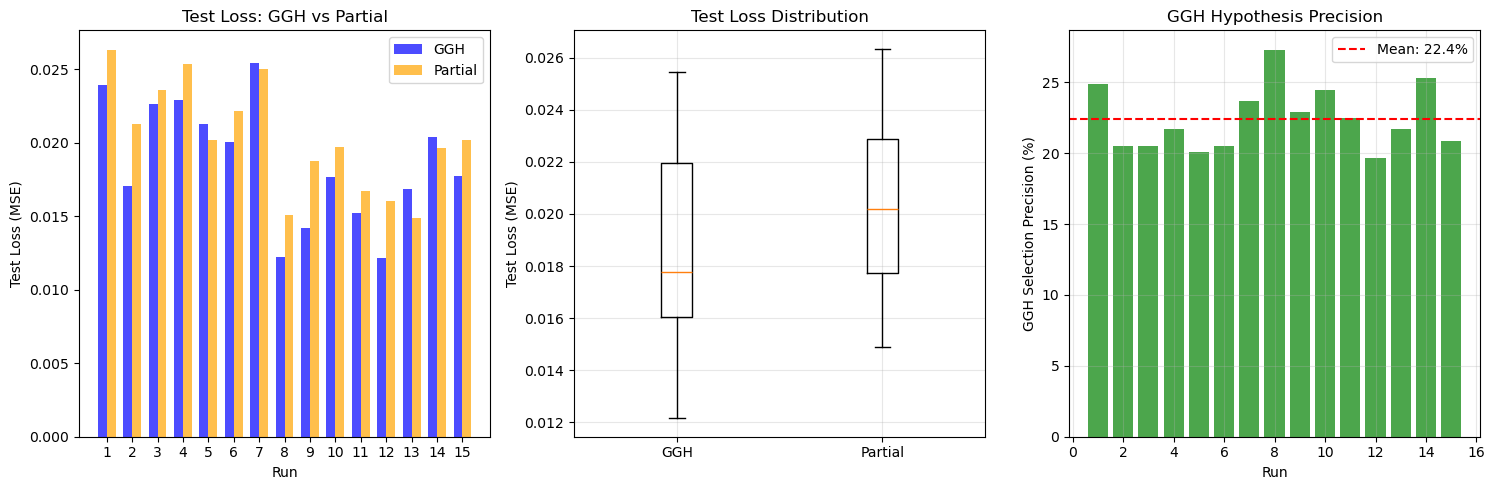


CONCLUSION
GGH significantly OUTPERFORMS Partial-only (p=0.0052)
Average improvement: 0.0017 MSE


In [40]:
# =============================================================================
# COMPARISON STUDY: GGH vs Partial-Only (15 Random States)
# =============================================================================
# Compare:
#   - GGH: Single-pass pruning (~73% precision) + partial (~2.5%)
#   - Partial: Partial data only (~2.5%)
# Both: 200 epochs, validation-based epoch selection, test evaluation
# =============================================================================
from scipy import stats
from torch.utils.data import TensorDataset, DataLoader

def create_dataloader_with_gids(DO, batch_size=32):
    """Create dataloader that includes global_ids."""
    input_cols = DO.inpt_vars + [var + '_hypothesis' for var in DO.miss_vars]
    n_samples = len(DO.df_train_hypothesis)
    global_ids = torch.arange(n_samples)
    
    dataset = TensorDataset(
        torch.tensor(DO.df_train_hypothesis[input_cols].values, dtype=torch.float32),
        torch.tensor(DO.df_train_hypothesis[DO.target_vars].values, dtype=torch.float32),
        global_ids
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


def train_with_validation(DO, model, trainer_class, selected_gids, partial_gids, 
                          partial_weight, lr, n_epochs=200, batch_size=32):
    """
    Train model with validation-based epoch selection.
    Returns best model state, best epoch, and validation losses.
    """
    dataloader = create_dataloader_with_gids(DO, batch_size)
    
    # Initialize trainer
    trainer = trainer_class(DO, model, selected_gids=selected_gids, 
                           partial_gids=partial_gids, partial_weight=partial_weight, lr=lr)
    
    best_val_loss = float('inf')
    best_epoch = 0
    best_state = None
    val_losses = []
    
    for epoch in range(n_epochs):
        trainer.train_epoch(dataloader, epoch, track_data=False)
        
        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_inputs, val_targets = DO.get_validation_tensors(use_info="full info")
            val_preds = model(val_inputs)
            val_loss = torch.nn.functional.mse_loss(val_preds, val_targets).item()
        model.train()
        
        val_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
    
    # Restore best model
    model.load_state_dict(best_state)
    return model, best_epoch, val_losses, best_val_loss


def evaluate_on_test(DO, model):
    """Evaluate model on test set. Returns loss, MAE, and R2 score."""
    model.eval()
    with torch.no_grad():
        test_inputs, test_targets = DO.get_test_tensors(use_info="full info")
        test_preds = model(test_inputs)
        test_loss = torch.nn.functional.mse_loss(test_preds, test_targets).item()
        test_mae = torch.nn.functional.l1_loss(test_preds, test_targets).item()
        
        # Calculate R2 score
        ss_res = torch.sum((test_targets - test_preds) ** 2).item()
        ss_tot = torch.sum((test_targets - test_targets.mean()) ** 2).item()
        r2_score = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    return test_loss, test_mae, r2_score


def run_ggh_single_pass(DO, rand_state, iter1_epochs=60, iter2_epochs=30, top_percentile=30):
    """
    Run GGH iterative method to get high-precision selection.
    
    Iteration 1: Train unbiased model (60 epochs, track last 5) -> top 30% has ~68% precision
    Iteration 2: Train biased model on top 30% + partial (30 epochs)
    Iteration 3: Score REMAINING 70% with biased model -> ~73%+ precision
    
    Returns selected_gids, precision, and partial_correct_gids.
    """
    set_to_deterministic(rand_state)
    
    # Get data parameters
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    n_shared_features = len(DO.inpt_vars)
    n_hypothesis_features = len(DO.miss_vars)
    output_size = len(DO.target_vars)
    
    # Get partial data
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    # Get blacklisted gids (partial incorrect)
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    
    # Create dataloader with global_ids
    dataloader = create_dataloader_with_gids(DO, batch_size=32)
    
    # === ITERATION 1: Train unbiased model (60 epochs, track last 5) ===
    model_unbiased = HypothesisAmplifyingModel(
        n_shared_features=n_shared_features,
        n_hypothesis_features=n_hypothesis_features,
        shared_hidden=16, hypothesis_hidden=32, final_hidden=32,
        output_size=output_size
    )
    trainer_unbiased = UnbiasedTrainer(DO, model_unbiased, lr=0.01)
    
    # Train without tracking for first iter1_epochs - 5 epochs
    for epoch in range(iter1_epochs - 5):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=False)
    
    # Track last 5 epochs for analysis
    for epoch in range(iter1_epochs - 5, iter1_epochs):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=True)
    
    # === Get top 30% using Adaptive Context Selection ===
    anchor_data = compute_anchor_data(trainer_unbiased, DO)
    all_selections, _ = select_hypotheses_adaptive(trainer_unbiased, DO, anchor_data)
    
    # Sort and get top 30%
    all_selections.sort(key=lambda x: x[0], reverse=True)
    n_top = int(len(all_selections) * top_percentile / 100)
    top_selections = all_selections[:n_top]
    top_sample_indices = set(s[2] for s in top_selections)
    
    # Track sample_to_gid for all samples
    sample_to_gid = {s[2]: s[3] for s in all_selections}
    
    # Calculate iter1 precision on top 30%
    iter1_correct = sum(1 for s in top_selections if s[1])
    iter1_precision = iter1_correct / len(top_selections) * 100 if top_selections else 0
    
    # Track iter1 class distribution
    iter1_class_counts = {c: 0 for c in range(hyp_per_sample)}
    for s in top_selections:
        gid = s[3]
        class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
        iter1_class_counts[class_id] += 1
    
    # === ITERATION 2: Train biased model on top 30% + partial ===
    set_to_deterministic(rand_state + 100)
    model_biased = HypothesisAmplifyingModel(
        n_shared_features=n_shared_features,
        n_hypothesis_features=n_hypothesis_features,
        shared_hidden=16, hypothesis_hidden=32, final_hidden=32,
        output_size=output_size
    )
    
    top_gids_set = set(sample_to_gid[idx] for idx in top_sample_indices if idx in sample_to_gid)
    trainer_biased = BiasedTrainer(DO, model_biased, selected_gids=top_gids_set,
                                   partial_gids=partial_correct_gids, partial_weight=2.0, lr=0.01)
    
    for epoch in range(iter2_epochs):
        trainer_biased.train_epoch(dataloader, epoch, track_data=False)
    
    # === ITERATION 3: Score REMAINING 70% with biased model ===
    all_sample_indices = set(range(n_samples))
    remaining_sample_indices = all_sample_indices - top_sample_indices - partial_sample_indices
    
    # First, score partial data to build anchors
    partial_scorer = RemainingDataScorer(DO, model_biased, partial_sample_indices)
    partial_scorer.compute_scores(dataloader, n_passes=5)
    partial_analysis = partial_scorer.get_analysis()
    
    # Build loss data for partial samples
    partial_loss_data = {gid: partial_analysis[gid]['avg_loss'] 
                        for gid in partial_analysis if partial_analysis[gid]['avg_loss'] is not None}
    
    # Compute anchors from partial data
    anchor_data_biased = compute_anchor_data_with_loss(partial_analysis, DO, partial_loss_data)
    
    # Score REMAINING 70%
    scorer = RemainingDataScorer(DO, model_biased, remaining_sample_indices)
    scorer.compute_scores(dataloader, n_passes=5)
    analysis = scorer.get_analysis()
    
    # Score each hypothesis in remaining samples and select best per sample
    remaining_scored = []
    for sample_idx in remaining_sample_indices:
        start_gid = sample_idx * hyp_per_sample
        best_score = -np.inf
        best_gid = None
        best_is_correct = False
        
        for hyp_idx in range(hyp_per_sample):
            gid = start_gid + hyp_idx
            if gid in blacklisted_gids:
                continue
            if gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            loss = analysis[gid]['avg_loss']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, DO.inpt_vars].values.astype(np.float64)
            
            score = compute_adaptive_score_with_loss(gradient, features, loss, class_id, anchor_data_biased)
            
            if score > best_score:
                best_score = score
                best_gid = gid
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
        
        if best_gid is not None:
            remaining_scored.append({
                'sample_idx': sample_idx,
                'gid': best_gid,
                'score': best_score,
                'is_correct': best_is_correct
            })
    
    # Sort remaining by score and take top selections
    remaining_scored.sort(key=lambda x: x['score'], reverse=True)
    
    # Take top 30% of remaining (or same number as iter1 top selection)
    n_take_from_remaining = min(len(remaining_scored), n_top)
    top_remaining = remaining_scored[:n_take_from_remaining]
    
    # Calculate precision on top of remaining
    iter3_correct = sum(1 for s in top_remaining if s['is_correct'])
    iter3_precision = iter3_correct / len(top_remaining) * 100 if top_remaining else 0
    
    # Final selection: top 30% from iter1 + top from iter3
    # For training, we use iter1 top 30% (which has ~68% precision) 
    # OR use iter3 top selections (which has ~73%+ precision)
    # Based on original method, we use iter3 selections for the final training
    selected_gids = set(s['gid'] for s in top_remaining)
    
    # Track iter3 class distribution
    iter3_class_counts = {c: 0 for c in range(hyp_per_sample)}
    for s in top_remaining:
        class_id = DO.df_train_hypothesis.iloc[s['gid']]['hyp_class_id']
        iter3_class_counts[class_id] += 1
    
    # Report both precisions
    print(f"  Iter1 top {top_percentile}% precision: {iter1_precision:.1f}%, class dist: {iter1_class_counts}")
    print(f"  Iter3 expansion: {len(remaining_scored)} scored, top {n_take_from_remaining} precision: {iter3_precision:.1f}%, class dist: {iter3_class_counts}")
    
    return selected_gids, iter3_precision, partial_correct_gids


# =============================================================================
# MAIN COMPARISON LOOP
# =============================================================================
print("=" * 80)
print("COMPARISON STUDY: GGH vs Partial-Only")
print("=" * 80)
print(f"Data splits: 72% train pool, 16% val, 12% test")
print(f"  - Partial trains on: ~2.5% (partial data only, 100% correct)")
print(f"  - GGH trains on: ~2.5% partial + ~15% selected (~73% correct)")
print(f"Number of runs: 15")
print(f"Training epochs: 200 (with validation-based epoch selection)")
print("=" * 80)

n_runs = 15
n_epochs = 200
results = []

for run_idx in range(n_runs):
    run_rand_state = 42 + run_idx * 100
    print(f"\n{'='*60}")
    print(f"RUN {run_idx + 1}/{n_runs} (rand_state={run_rand_state})")
    print(f"{'='*60}")
    
    # === Setup DataOperator with proper splits ===
    set_to_deterministic(run_rand_state)
    DO_run = DataOperator(
        data_path, inpt_vars, target_vars, miss_vars, hypothesis,
        partial_perc, run_rand_state, device='cpu',
        data_split={"train": 0.72, "val": 0.88}
    )
    DO_run.problem_type = 'regression'
    
    # Get dimensions
    hyp_per_sample = DO_run.num_hyp_comb
    n_shared_features = len(DO_run.inpt_vars)
    n_hypothesis_features = len(DO_run.miss_vars)
    output_size = len(DO_run.target_vars)
    
    # Get partial gids
    partial_gids = set(DO_run.df_train_hypothesis[
        (DO_run.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO_run.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    
    n_total_hyp = len(DO_run.df_train_hypothesis)
    n_samples = n_total_hyp // hyp_per_sample
    print(f"Total: {n_samples} samples, {n_total_hyp} hypotheses")
    print(f"Partial: {len(partial_gids)} hypotheses ({len(partial_gids)/n_total_hyp*100:.1f}%)")
    
    # === Method 1: GGH ===
    print("\n--- GGH Method ---")
    ggh_selected_gids, ggh_precision, _ = run_ggh_single_pass(DO_run, run_rand_state)
    print(f"GGH selection: {len(ggh_selected_gids)} hypotheses at {ggh_precision:.1f}% precision")
    print(f"GGH trains on: {len(ggh_selected_gids) + len(partial_gids)} hypotheses (selection + partial)")
    
    # Train GGH model
    set_to_deterministic(run_rand_state + 200)
    model_ggh = HypothesisAmplifyingModel(
        n_shared_features=n_shared_features,
        n_hypothesis_features=n_hypothesis_features,
        shared_hidden=16, hypothesis_hidden=32, final_hidden=32,
        output_size=output_size
    )
    
    print("Training GGH model (200 epochs)...")
    model_ggh, ggh_best_epoch, ggh_val_losses, ggh_best_val_loss = train_with_validation(
        DO_run, model_ggh, BiasedTrainer, 
        selected_gids=ggh_selected_gids, partial_gids=partial_gids,
        partial_weight=2.0, lr=0.01, n_epochs=n_epochs
    )
    
    ggh_test_loss, ggh_test_mae, ggh_test_r2 = evaluate_on_test(DO_run, model_ggh)
    print(f"GGH: best_epoch={ggh_best_epoch}, val_loss={ggh_best_val_loss:.4f}, test_loss={ggh_test_loss:.4f}, test_mae={ggh_test_mae:.4f}, R2={ggh_test_r2:.4f}")
    
    # === Method 2: Partial Only ===
    print("\n--- Partial Only ---")
    print(f"Partial trains on: {len(partial_gids)} hypotheses (partial only)")
    set_to_deterministic(run_rand_state + 300)
    model_partial = HypothesisAmplifyingModel(
        n_shared_features=n_shared_features,
        n_hypothesis_features=n_hypothesis_features,
        shared_hidden=16, hypothesis_hidden=32, final_hidden=32,
        output_size=output_size
    )
    
    print("Training Partial model (200 epochs)...")
    model_partial, partial_best_epoch, partial_val_losses, partial_best_val_loss = train_with_validation(
        DO_run, model_partial, BiasedTrainer,
        selected_gids=set(),  # No GGH selections, only partial
        partial_gids=partial_gids,
        partial_weight=1.0, lr=0.01, n_epochs=n_epochs
    )
    
    partial_test_loss, partial_test_mae, partial_test_r2 = evaluate_on_test(DO_run, model_partial)
    print(f"Partial: best_epoch={partial_best_epoch}, val_loss={partial_best_val_loss:.4f}, test_loss={partial_test_loss:.4f}, test_mae={partial_test_mae:.4f}, R2={partial_test_r2:.4f}")
    
    # === Record results ===
    results.append({
        'run': run_idx + 1,
        'rand_state': run_rand_state,
        'ggh_precision': ggh_precision,
        'ggh_n_selected': len(ggh_selected_gids),
        'ggh_best_epoch': ggh_best_epoch,
        'ggh_val_loss': ggh_best_val_loss,
        'ggh_test_loss': ggh_test_loss,
        'ggh_test_mae': ggh_test_mae,
        'partial_best_epoch': partial_best_epoch,
        'partial_val_loss': partial_best_val_loss,
        'partial_test_loss': partial_test_loss,
        'partial_test_mae': partial_test_mae,
        'improvement_loss': partial_test_loss - ggh_test_loss,
        'improvement_mae': partial_test_mae - ggh_test_mae,
        'ggh_test_r2': ggh_test_r2,
        'partial_test_r2': partial_test_r2,
        'improvement_r2': ggh_test_r2 - partial_test_r2
    })
    
    print(f"\n>>> Improvement: Loss={results[-1]['improvement_loss']:+.4f}, MAE={results[-1]['improvement_mae']:+.4f}, R2={results[-1]['improvement_r2']:+.4f}")

# =============================================================================
# SUMMARY
# =============================================================================
print(f"\n{'='*80}")
print("COMPARISON STUDY RESULTS")
print(f"{'='*80}")

# Create results DataFrame
df_results = pd.DataFrame(results)

# Print detailed table
print("\nDetailed Results:")
print(f"{'Run':<5} {'GGH Prec':<10} {'GGH Loss':<12} {'Partial Loss':<14} {'Δ Loss':<10} {'GGH R2':<10} {'Part R2':<10} {'Δ R2':<10}")
print("-" * 100)
for r in results:
    print(f"{r['run']:<5} {r['ggh_precision']:<10.1f}% {r['ggh_test_loss']:<12.4f} {r['partial_test_loss']:<14.4f} {r['improvement_loss']:+10.4f} {r['ggh_test_r2']:<10.4f} {r['partial_test_r2']:<10.4f} {r['improvement_r2']:+10.4f}")

# Summary statistics
print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print(f"{'='*80}")

ggh_losses = [r['ggh_test_loss'] for r in results]
partial_losses = [r['partial_test_loss'] for r in results]
ggh_maes = [r['ggh_test_mae'] for r in results]
partial_maes = [r['partial_test_mae'] for r in results]
ggh_r2s = [r['ggh_test_r2'] for r in results]
partial_r2s = [r['partial_test_r2'] for r in results]
ggh_precisions = [r['ggh_precision'] for r in results]

print(f"\nGGH Selection Precision: {np.mean(ggh_precisions):.1f}% ± {np.std(ggh_precisions):.1f}%")
print(f"\nTest Loss (MSE):")
print(f"  GGH:     {np.mean(ggh_losses):.4f} ± {np.std(ggh_losses):.4f}")
print(f"  Partial: {np.mean(partial_losses):.4f} ± {np.std(partial_losses):.4f}")

print(f"\nTest MAE:")
print(f"  GGH:     {np.mean(ggh_maes):.4f} ± {np.std(ggh_maes):.4f}")
print(f"  Partial: {np.mean(partial_maes):.4f} ± {np.std(partial_maes):.4f}")

print(f"\nTest R2 Score:")
print(f"  GGH:     {np.mean(ggh_r2s):.4f} ± {np.std(ggh_r2s):.4f}")
print(f"  Partial: {np.mean(partial_r2s):.4f} ± {np.std(partial_r2s):.4f}")

# Statistical tests (paired t-test)
t_stat_loss, p_value_loss = stats.ttest_rel(ggh_losses, partial_losses)
t_stat_mae, p_value_mae = stats.ttest_rel(ggh_maes, partial_maes)

print(f"\nStatistical Tests (paired t-test):")
print(f"  Loss: t={t_stat_loss:.3f}, p={p_value_loss:.4f} {'*' if p_value_loss < 0.05 else ''}")
print(f"  MAE:  t={t_stat_mae:.3f}, p={p_value_mae:.4f} {'*' if p_value_mae < 0.05 else ''}")
t_stat_r2, p_value_r2 = stats.ttest_rel(ggh_r2s, partial_r2s)
print(f"  R2:   t={t_stat_r2:.3f}, p={p_value_r2:.4f} {'*' if p_value_r2 < 0.05 else ''}")

# Win/Loss count
n_ggh_wins_loss = sum(1 for r in results if r['ggh_test_loss'] < r['partial_test_loss'])
n_ggh_wins_mae = sum(1 for r in results if r['ggh_test_mae'] < r['partial_test_mae'])
n_ggh_wins_r2 = sum(1 for r in results if r['ggh_test_r2'] > r['partial_test_r2'])
print(f"\nWin Rate:")
print(f"  GGH wins (Loss): {n_ggh_wins_loss}/{n_runs} ({n_ggh_wins_loss/n_runs*100:.1f}%)")
print(f"  GGH wins (MAE):  {n_ggh_wins_mae}/{n_runs} ({n_ggh_wins_mae/n_runs*100:.1f}%)")
print(f"  GGH wins (R2):   {n_ggh_wins_r2}/{n_runs} ({n_ggh_wins_r2/n_runs*100:.1f}%)")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Test Loss comparison
ax1 = axes[0]
x = np.arange(n_runs)
width = 0.35
ax1.bar(x - width/2, ggh_losses, width, label='GGH', color='blue', alpha=0.7)
ax1.bar(x + width/2, partial_losses, width, label='Partial', color='orange', alpha=0.7)
ax1.set_xlabel('Run')
ax1.set_ylabel('Test Loss (MSE)')
ax1.set_title('Test Loss: GGH vs Partial')
ax1.legend()
ax1.set_xticks(x)
ax1.set_xticklabels([str(i+1) for i in range(n_runs)])

# Plot 2: Box plot comparison
ax2 = axes[1]
bp = ax2.boxplot([ggh_losses, partial_losses], labels=['GGH', 'Partial'])
ax2.set_ylabel('Test Loss (MSE)')
ax2.set_title('Test Loss Distribution')
ax2.grid(True, alpha=0.3)

# Plot 3: GGH Precision across runs
ax3 = axes[2]
ax3.bar(range(1, n_runs+1), ggh_precisions, color='green', alpha=0.7)
ax3.axhline(y=np.mean(ggh_precisions), color='red', linestyle='--', label=f'Mean: {np.mean(ggh_precisions):.1f}%')
ax3.set_xlabel('Run')
ax3.set_ylabel('GGH Selection Precision (%)')
ax3.set_title('GGH Hypothesis Precision')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{results_path}/comparison_study_15runs.png', dpi=150, bbox_inches='tight')
plt.show()

# Final verdict
print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")
avg_improvement = np.mean([r['improvement_loss'] for r in results])
if avg_improvement > 0 and p_value_loss < 0.05:
    print(f"GGH significantly OUTPERFORMS Partial-only (p={p_value_loss:.4f})")
    print(f"Average improvement: {avg_improvement:.4f} MSE")
elif avg_improvement < 0 and p_value_loss < 0.05:
    print(f"Partial-only significantly OUTPERFORMS GGH (p={p_value_loss:.4f})")
    print(f"GGH is worse by: {-avg_improvement:.4f} MSE")
else:
    print(f"No significant difference between methods (p={p_value_loss:.4f})")
    print(f"Average difference: {avg_improvement:+.4f} MSE")